In [1]:
from numba import cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import numpy as np
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.pyplot as plt
import cv2

#Labwork3

(1440, 2560, 3)


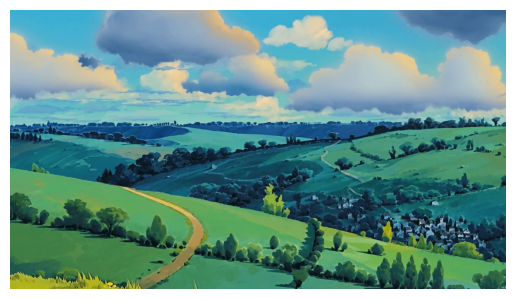

In [2]:
# load image from file(matplotlib's imread)
with cbook.get_sample_data('/content/sample.jpg') as image_file:
  img = plt.imread(image_file)

print(img.shape)
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

plt.show()

In [3]:
# Flatten image to 1D array of RGB
h, w, c = img.shape
total_pixel = h * w
flat_img = img.reshape(-1, 3).astype(np.float32)

print(flat_img)

[[ 66. 179. 209.]
 [ 65. 178. 210.]
 [ 60. 174. 208.]
 ...
 [ 48. 107.  79.]
 [ 45. 101.  72.]
 [ 39.  92.  64.]]


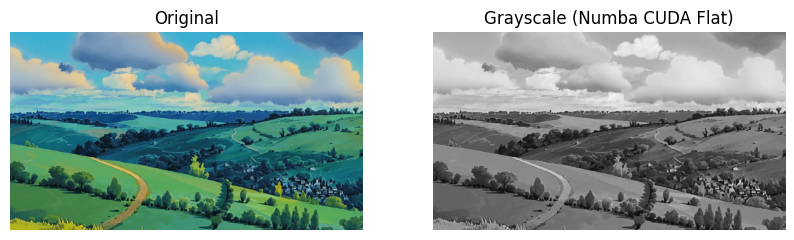

In [4]:
# Allocate output grayscale image
gray_img = np.zeros(total_pixel, dtype=np.uint8)

# Copy data to GPU
d_img = cuda.to_device(flat_img)
d_gray = cuda.to_device(gray_img)

# CUDA kernel (1 thread = 1 pixel)
@cuda.jit
def rgb2gray_flat(img, gray, total_pixel):
    i = cuda.grid(1)  # 1D thread index
    if i < total_pixel:
        r = img[i, 0]
        g = img[i, 1]
        b = img[i, 2]
        gray[i] = (r + g + b) / 3

# Configure GPU
threadsperblock = 256
blockspergrid = (total_pixel + threadsperblock - 1) // threadsperblock

# Launch kernel
rgb2gray_flat[blockspergrid, threadsperblock](d_img, d_gray, total_pixel)

# Copy back
gray_result = d_gray.copy_to_host().reshape(h, w)

# Show result
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(gray_result, cmap="gray")
plt.title("Grayscale (Numba CUDA Flat)")
plt.axis("off")

plt.show()

#Labwork4

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import time

(1440, 2560, 3)


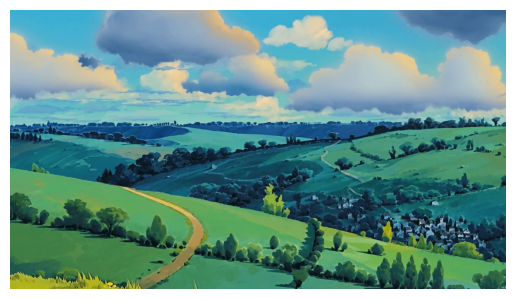

In [6]:
# load image from file(matplotlib's imread)
with cbook.get_sample_data('/content/sample.jpg') as image_file:
  img = plt.imread(image_file)

print(img.shape)
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

plt.show()

In [16]:
h, w, c = img.shape
gray_img = np.zeros((h, w), dtype=np.uint8)

In [17]:
# Copy to GPU
d_img = cuda.to_device(img)
d_gray = cuda.to_device(gray_img)

Execution time (2D blocks): 0.078860 seconds


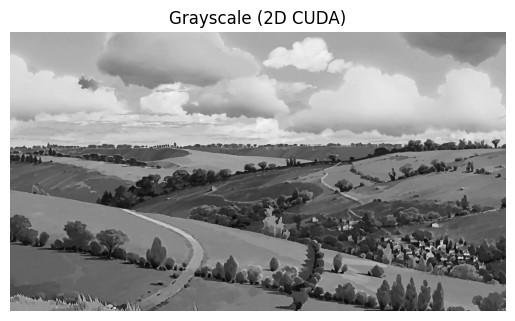

In [18]:
# CUDA kernel
@cuda.jit

def grayscale(src, dst):
  x, y = cuda.grid(2)

  if x < src.shape[0] and y < src.shape[1]:
    g = np.uint8((src[x, y, 0] + src[x, y, 1] + src[x, y, 2]) / 3)
    dst[x, y] = g

# Configure GPU launch
threadsperblock = (8, 8)
blockspergrid_x = (h + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (w + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
grayscale[blockspergrid, threadsperblock](d_img, d_gray)
end = time.time()

print(f"Execution time (2D blocks): {end - start:.6f} seconds")

# Copy result back
gray_result = d_gray.copy_to_host()

# Show images
plt.imshow(gray_result, cmap='gray')
plt.title("Grayscale (2D CUDA)")
plt.axis("off")

plt.show()